In [1]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod
 
xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [3]:
season = 'JFM'

### Filename for saved plots

In [4]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [5]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [6]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [7]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [8]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [9]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [10]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [11]:
ds_smr_sat = xr.open_dataset(sat_filename)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [12]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/20)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    BC_conc                                     (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [13]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [14]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

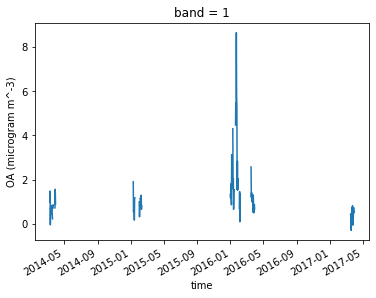

In [15]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [16]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.72166652, 1.3047685 ])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

## *MASK BY BC: 

In [17]:
ds_smr_sat_JA['OA (microgram m^-3)'].count()

<xarray.DataArray 'OA (microgram m^-3)' ()>
array(92)
Coordinates:
    band     int64 1

In [18]:
ds_smr_sat_JA = ds_smr_sat_JA.where(ds_smr_sat_JA['BC_conc'].fillna(0)<.05)

In [19]:
ds_smr_sat_JA['OA (microgram m^-3)'].count()

<xarray.DataArray 'OA (microgram m^-3)' ()>
array(32)
Coordinates:
    band     int64 1

In [20]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.47732728, 0.71735067])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

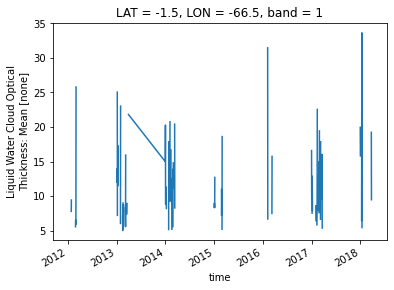

In [21]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [22]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [23]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [24]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 630, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-01-01 ... 2018-03-31
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 216.0 192.0 169.0 ... nan nan
    CER (micrometer)     (time, LAT, LON) float32 17.54 16.1 16.06 ... nan nan
    COT                  (time, LAT, LON) float32 18.3 17.82 14.13 ... nan nan

In [25]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [26]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [27]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-12 -1.5 -66.5            -0.040000         289.0         22.750000   
           -2.5 -66.5            -0.040000         122.0         21.939999   
                -65.5            -0.040000         155.0         23.500000   
           -3.5 -53.5            -0.040000         124.0         23.959999   
                -52.5            -0.040000         175.0         21.449999   
...                                    ...           ...               ...   
2017-03-30 -7.5 -65.5             0.528895         104.0         27.219999   
                -64.5             0.528895          81.0         24.539999   
                -63.5             0.528895         120.0         21.889999   
                -62.5             0.528895         138.0         22.000000   
                -61.5             0.528895         112.0         25.910000   

                         COT  
time       LAT  LON           
2014-03-12 -1.5 -66.5  20.42  
           -2.5 -66.5   9.61  
                -65.5  10.05  
           -3.5 -53.5   7.99  
                -52.5  12.28  
...                      ...  
2017-03-30 -7.5 -65.5   5.78  
                -64.5   5.21  
                -63.5   8.01  
                -62.5   9.01  
                -61.5   6.69  

[929 rows x 4 columns]

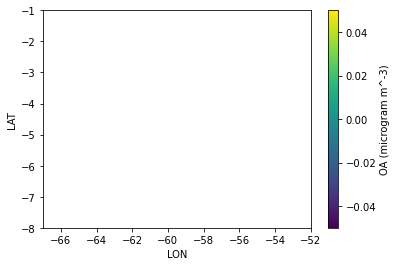

In [28]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [29]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [30]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


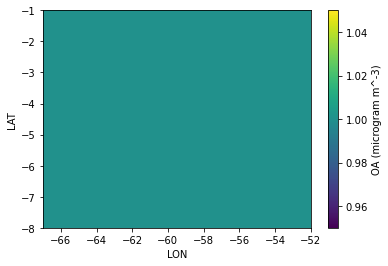

In [31]:
(~da_drop_pixels).plot()

In [32]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

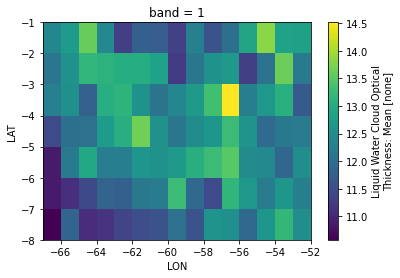

In [33]:
ds_smr_sat_JAs['COT'].mean('time').plot()

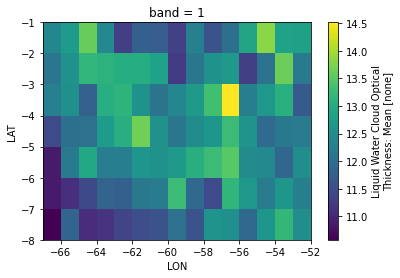

In [34]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([ 315.,  315., 1260.,  735.,  420.,  210.,    0.,    0.,    0.,
         105.]),
 array([-2.88634982e-01, -2.47123405e-03,  2.83692514e-01,  5.69856262e-01,
         8.56020011e-01,  1.14218376e+00,  1.42834751e+00,  1.71451126e+00,
         2.00067500e+00,  2.28683875e+00,  2.57300250e+00]),
 <BarContainer object of 10 artists>)

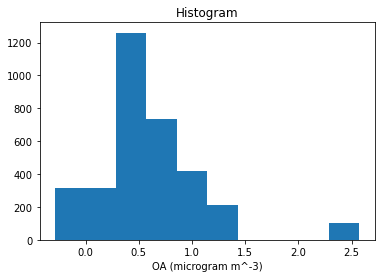

In [35]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [36]:
dic_OA_percentiles = dict()

In [37]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [38]:
df_hyy_1

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       lat  lon                                                          
2012-01-01 -7.5 -66.5                  NaN           NaN               NaN   
2012-01-02 -7.5 -66.5                  NaN           NaN               NaN   
2012-01-03 -7.5 -66.5                  NaN          73.0         18.779999   
2012-01-04 -7.5 -66.5                  NaN         114.0         18.580000   
2012-01-05 -7.5 -66.5                  NaN           NaN               NaN   
...                                    ...           ...               ...   
2018-03-27 -1.5 -52.5                  NaN         202.0         23.559999   
2018-03-28 -1.5 -52.5                  NaN           NaN               NaN   
2018-03-29 -1.5 -52.5                  NaN           NaN               NaN   
2018-03-30 -1.5 -52.5                  NaN         149.0         22.160000   
2018-03-31 -1.5 -52.5                  NaN           NaN               NaN   

                         COT  
time       lat  lon           
2012-01-01 -7.5 -66.5    NaN  
2012-01-02 -7.5 -66.5    NaN  
2012-01-03 -7.5 -66.5   5.89  
2012-01-04 -7.5 -66.5   8.63  
2012-01-05 -7.5 -66.5    NaN  
...                      ...  
2018-03-27 -1.5 -52.5  12.78  
2018-03-28 -1.5 -52.5    NaN  
2018-03-29 -1.5 -52.5    NaN  
2018-03-30 -1.5 -52.5  10.29  
2018-03-31 -1.5 -52.5    NaN  

[66150 rows x 4 columns]

df_smr_sat_JAsad model data:

## Load model data

In [39]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 

models =[model_name_noresm,model_name_echam,model_name_ec_earth]

### Settings

In [40]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [41]:
l=-10
((l)%360)

350

In [42]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [43]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [44]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [45]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [46]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [47]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [48]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [49]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [50]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [51]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [52]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [53]:
cases_echam = [case_name_echam]

### EC-Earth

In [54]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [55]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [56]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [57]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [58]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [59]:
cases_ec_earth = [case_name_ec_earth]

### Read in model data

In [60]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month



In [61]:
df_mod_ec_earth.to_xarray()

<xarray.Dataset>
Dimensions:                   (time: 2558, lat: 10, lon: 22)
Coordinates:
  * time                      (time) datetime64[ns] 2011-12-31 ... 2018-12-31
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
Data variables: (12/107)
    station                   (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO'
    cc_all                    (time, lat, lon) float64 nan nan nan ... nan nan
    re_liq                    (time, lat, lon) float64 nan nan nan ... nan nan
    CWP                       (time, lat, lon) float64 nan nan nan ... nan nan
    tcwv                      (time, lat, lon) float64 nan nan nan ... nan nan
    tciw                      (time, lat, lon) float64 nan nan nan ... nan nan
    ...                        ...
    T                         (time, lat, lon) float64 nan nan ... 300.6 300.6
    M_DUCOS                   (time, lat, lon) float64 nan nan ... 5.649e-10
    M_DUCOI                   (time, lat, lon) float64 nan nan ... 2.493e-09
    N100_STP                  (time, lat, lon) float64 nan nan ... 367.3 367.3
    M_SOACOS                  (time, lat, lon) float64 nan nan ... 0.01402
    year                      (time, lat, lon) int64 2011 2011 ... 2018 2018

## Pick out months:

In [62]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

<AxesSubplot:ylabel='Frequency'>

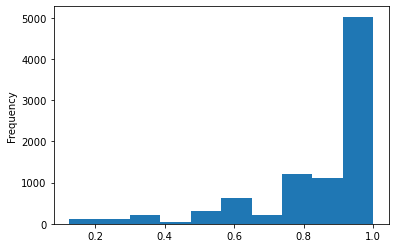

In [63]:
df_mod_echam['cl_time_ct'].plot.hist()

### Organize data in dictionary

In [64]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df['Observations'] = df_hyy_1



### *Scale CWP down for EC-Earth

In [65]:
_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

In [66]:
_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7
    
    _df['scaled'] = True
    print('scaling CWP in EC-Earth')
dic_df[model_name_ec_earth]  = _df

scaling CWP in EC-Earth


<AxesSubplot:ylabel='Frequency'>

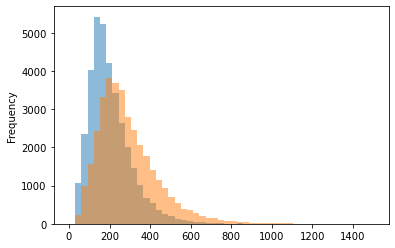

In [67]:
dic_df[model_name_ec_earth]['CWP'].plot.hist(alpha=.5, bins=np.linspace(0,1500))
dic_df[model_name_ec_earth]['CWP_orig'].plot.hist(alpha=.5, bins=np.linspace(0,1500))

## Check everythign is fine:

In [68]:
for mod in dic_df.keys():
    print(dic_df[mod].to_xarray())

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... 192.4 192.2
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    ...              ...
    ORG_mass        (time, lat, lon) float64 9.209e-10 9.209e-10 ... 3.671e-10
    N200            (time, lat, lon) float64 8.246 4.128 9.056 ... 18.92 11.64
    T               (time

## Rename variables:


<AxesSubplot:ylabel='Frequency'>

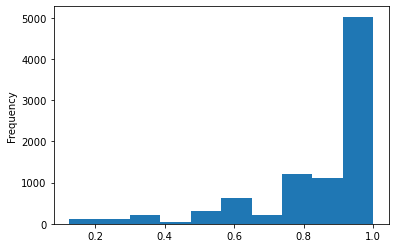

In [69]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [70]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    

}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [71]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [72]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [73]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

dropping OA in favor of OA_STP


In [74]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... 192.4 192.2
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    ...              ...
    ORG_mass        (time, lat, lon) float64 9.209e-10 9.209e-10 ... 3.671e-10
    N200            (time, lat, lon) float64 8.246 4.128 9.056 ... 18.92 11.64
    T        

<AxesSubplot:ylabel='Frequency'>

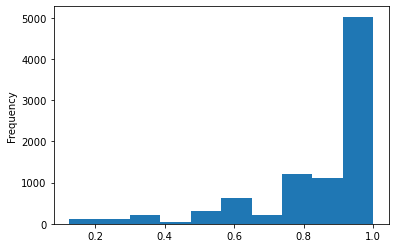

In [75]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

## Group by cloud water path 

#### Predefined bins

In [76]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])




## Mask data

### moved to pre-processing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top

df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

### Bin model data:

CWP above 50. 

In [77]:
varl_categories = ['OA']#,'CLDFREE'

In [78]:
varlist_notna = ['OA','CWP','COT','r_eff']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [79]:
dic_df['EC-Earth']['N100-500_STP']

time        lat    lon   
2012-01-01  -7.37  293.20    274.027016
                   293.91    274.027016
                   294.61    274.027016
                   295.31    274.027016
                   296.02    274.027016
                                ...    
2018-03-31  -1.05  305.16    279.262464
                   305.86    279.262464
                   306.56    279.262464
                   307.27    279.262464
                   307.97    279.262464
Name: N100-500_STP, Length: 139040, dtype: float64

In [80]:
dic_df.keys()
ds_ec = dic_df['EC-Earth'].to_xarray()

In [81]:
a = dic_df['NorESM'].T.duplicated()

In [82]:
a.index

Index(['station', 'FSUS_DRF', 'FLNTCDRF', 'FREQL', 'FLNS', 'FSNSC', 'FLNT',
       'transmittance', 'TOT_CLD_VISTAU', 'ACTREL', 'TOT_CLD_VISTAU_s',
       'TGCLDLWP', 'FCTL', 'FCTI', 'CWP', 'FSUTADRF', 'COT', 'TGCLDCWP',
       'TOT_ICLD_VISTAU_s', 'FLNSC', 'FSDSCDRF', 'ACTNL', 'FSNT_DRF',
       'CLDFREE', 'FLNT_DRF', 'optical_depth', 'FLUS', 'FSDS_DRF', 'CLDTOT',
       'FLUTC', 'FSNT', 'r_eff', 'TGCLDCWP_incld', 'FSNS', 'TGCLDIWP', 'FREQI',
       'FSNTCDRF', 'TOT_ICLD_VISTAU', 'month', 'ismonth1', 'ismonth2',
       'ismonth3', 'ismonth4', 'ismonth5', 'ismonth6', 'ismonth7', 'ismonth8',
       'ismonth9', 'ismonth10', 'ismonth11', 'ismonth12', 'isJuly', 'isAug',
       'isJA', 'isSummer', 'ilev', 'lev', 'N100-500_STP', 'BC_AX', 'OM_NI',
       'N50_STP', 'BC_AI', 'DOD500', 'SOA_A1', 'BC_NI', 'BC_N', 'SO4_A2',
       'BC_A', 'N100_STP', 'N200_STP', 'SOA_LV', 'PS', 'OM_AC', 'SS_A1',
       'DOD440', 'SO4_NA', 'OM_AI', 'SS_A2', 'BC_AC', 'DST_A3', 'N150', 'OA',
       'SFmonoterp', 'T'

In [83]:
ds_no = dic_df['NorESM'].to_xarray()

In [84]:
dic_df[model_name_echam]

station     lcdnc_cm3  min_cl_tempair  ceff  \
time       lat       lon                                                   
2012-01-01 -2.797890 294.375    ATTO  4.430701e-35       213.28612   0.0   
                     296.250    ATTO  9.719341e-35       213.20883   0.0   
                     298.125    ATTO  6.922904e-35       212.94533   0.0   
                     300.000    ATTO -5.966645e-36       212.92976   0.0   
                     301.875    ATTO  3.178818e-35       213.12698   0.0   
...                              ...           ...             ...   ...   
2018-03-31 -6.528409 300.000    ATTO           NaN             NaN   NaN   
                     301.875    ATTO  1.983362e-35       187.98352   0.0   
                     303.750    ATTO           NaN             NaN   NaN   
                     305.625    ATTO           NaN             NaN   NaN   
                     307.500    ATTO  1.442527e-34             NaN   0.0   

                              cl_time  lcdnc_ct_cm3    ceff_ct         CWP  \
time       lat       lon                                                     
2012-01-01 -2.797890 294.375      0.0      9.650340  16.343527  224.435970   
                     296.250      0.0      2.416409  14.716598  183.763240   
                     298.125      0.0      4.669168  16.791536   59.977024   
                     300.000      0.0     18.118134  12.863009   53.875362   
                     301.875      0.0     36.350810  16.347946  239.690460   
...                               ...           ...        ...         ...   
2018-03-31 -6.528409 300.000      NaN           NaN        NaN         NaN   
                     301.875      0.0      1.426565  15.361828   89.560780   
                     303.750      NaN           NaN        NaN         NaN   
                     305.625      NaN           NaN        NaN         NaN   
                     307.500      0.0      2.806612   4.974741  129.151900   

                                    COT  cl_time_ct  ...  emi_monot_bio  \
time       lat       lon                             ...                  
2012-01-01 -2.797890 294.375  19.230902      1.0000  ...   1.513681e-10   
                     296.250  16.136960      0.8125  ...   1.969307e-10   
                     298.125   8.856040      1.0000  ...   3.431866e-10   
                     300.000   6.757799      1.0000  ...   2.544260e-10   
                     301.875  26.154974      0.6250  ...   0.000000e+00   
...                                 ...         ...  ...            ...   
2018-03-31 -6.528409 300.000        NaN         NaN  ...   1.748343e-10   
                     301.875   6.611546      0.8750  ...   2.039204e-10   
                     303.750        NaN         NaN  ...   2.040333e-10   
                     305.625        NaN         NaN  ...   2.136222e-10   
                     307.500  12.504495      1.0000  ...   1.732347e-10   

                                   N100   mmrtrN100  emi_isop_bio  \
time       lat       lon                                            
2012-01-01 -2.797890 294.375  99.768880  67215815.0  9.137577e-10   
                     296.250  58.768524  67215815.0  1.030914e-09   
                     298.125  36.833138  67215815.0  5.333989e-10   
                     300.000  92.452910  67215815.0  6.520385e-10   
                     301.875  93.162950  67215815.0  0.000000e+00   
...                                 ...         ...           ...   
2018-03-31 -6.528409 300.000  10.856729  30489130.0  1.870816e-09   
                     301.875  30.027435  30489130.0  7.860342e-10   
                     303.750  38.189760  30489130.0  7.879652e-10   
                     305.625  65.233810  30489130.0  4.820738e-10   
                     307.500  52.928240  30489130.0  6.906081e-10   

                                  ORG_mass       N200          T     mmrtrN50  \
time       lat       lon                                              

In [85]:
n_bins = 7

for model_name in dic_df.keys():

    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name =='EC-Earth':
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].notna().all(axis=1)]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
1.2244470500000002
2.5705137
NorESM
4.626595931252206
7.5212583525882515
EC-Earth


/tmp/ipykernel_154556/3884036908.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].notna().all(axis=1)]
/tmp/ipykernel_154556/3884036908.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_154556/3884036908.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_154556/3884036908.py:32: SettingWithCopyWarning: 
A

2.8693897431128184
3.564456930243315
Observations
0.4969827641832945
0.7375


In [86]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn)
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_JFM.csv


33rd      66th  med_high   med_low      diff
ECHAM-SALSA   1.224447  2.570514  3.513468  0.784696  1.346067
NorESM        4.626596  7.521258  9.894645  3.607368  2.894662
EC-Earth      2.869390  3.564457  4.232263  2.460919  0.695067
Observations  0.496983  0.737500  0.993561  0.367500  0.240517

<AxesSubplot:ylabel='Frequency'>

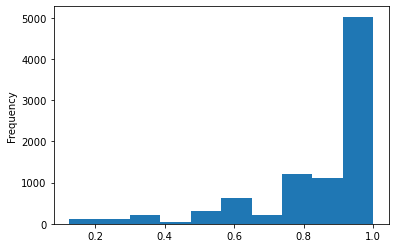

In [87]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [88]:
OA_percentile_df

33rd      66th  med_high   med_low      diff
ECHAM-SALSA   1.224447  2.570514  3.513468  0.784696  1.346067
NorESM        4.626596  7.521258  9.894645  3.607368  2.894662
EC-Earth      2.869390  3.564457  4.232263  2.460919  0.695067
Observations  0.496983  0.737500  0.993561  0.367500  0.240517

## Quantile cut

In [89]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [90]:
palette = 'Set2'

In [91]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [92]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
410
NorESM
359
EC-Earth
351
Observations
21


922
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


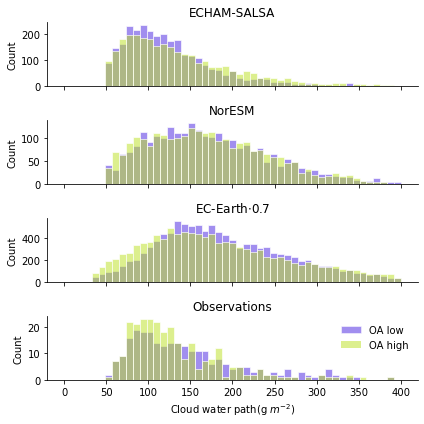

In [93]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,400)
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



264
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


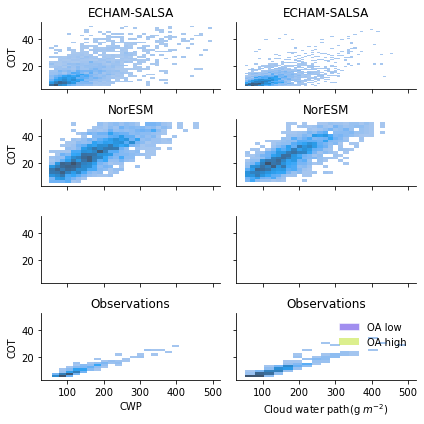

In [94]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key=='EC-Earth':
        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



264
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


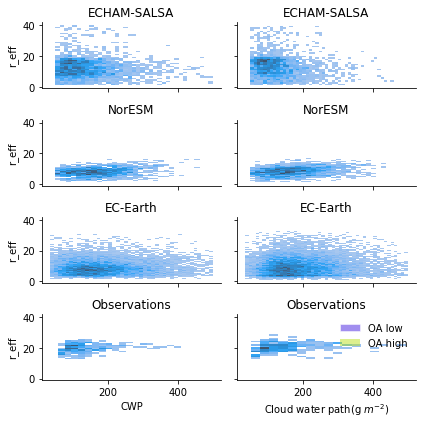

In [95]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [96]:
hue_v = 'OA high'

922
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


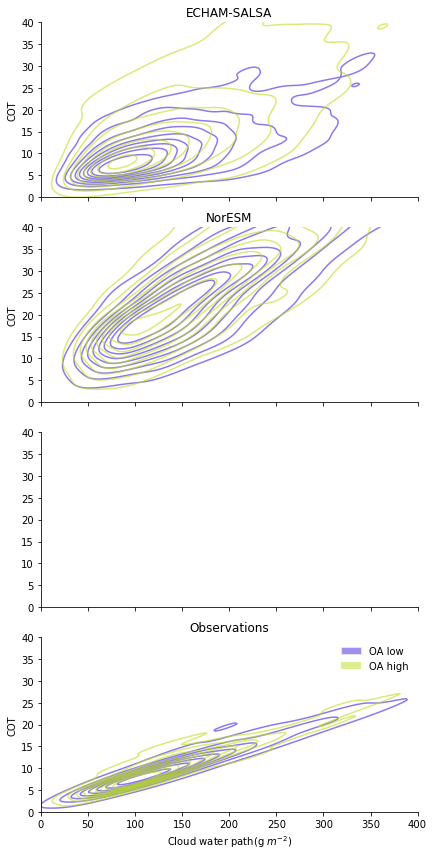

In [97]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key=='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

929
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFM.png


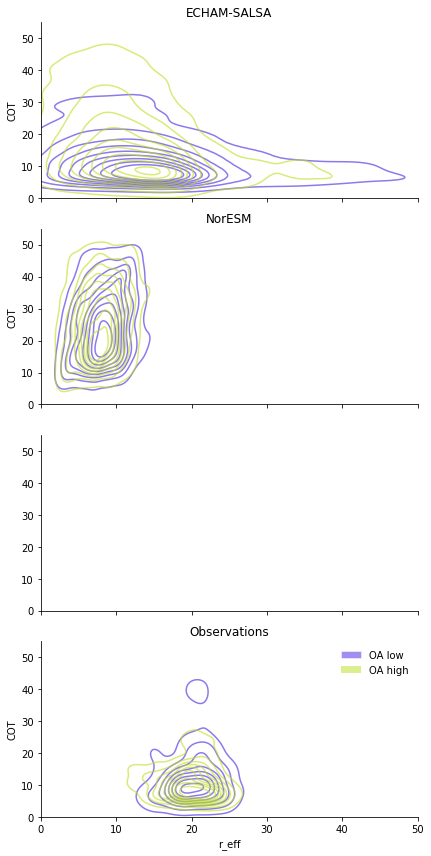

In [98]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key =='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

922
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


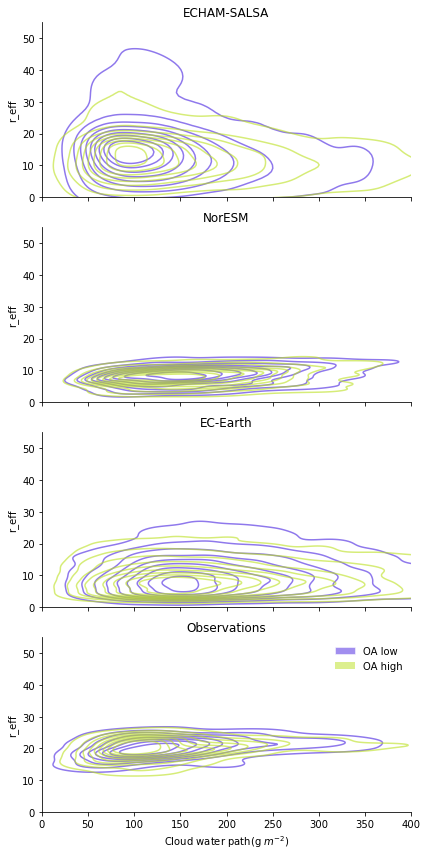

In [99]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

# fig.savefig(fn, dpi=150)
fig.tight_layout()
# fig.savefig(fn, dpi=150)
# fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

<AxesSubplot:ylabel='Frequency'>

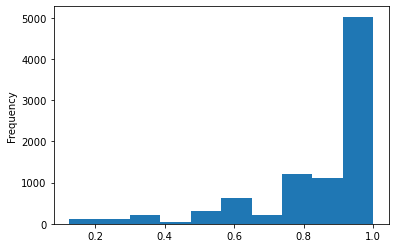

In [100]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [101]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8955

In [102]:
len(dic_df['ECHAM-SALSA'])

8955

In [103]:
len(dic_df['NorESM'].dropna())

5044

8955
7959
35427
929
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFM.png


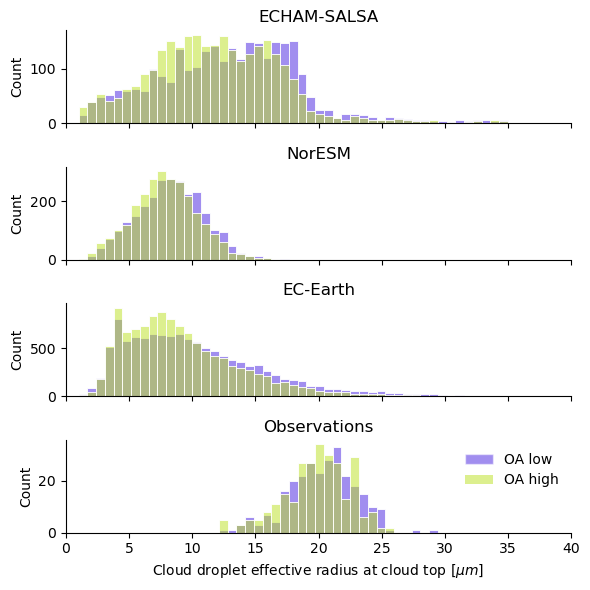

In [104]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [105]:
dic_df[model_name_echam]

station     lcdnc_cm3  min_cl_tempair  ceff  \
time       lat       lon                                                   
2012-01-01 -2.797890 294.375    ATTO  4.430701e-35       213.28612   0.0   
                     296.250    ATTO  9.719341e-35       213.20883   0.0   
                     298.125    ATTO  6.922904e-35       212.94533   0.0   
                     300.000    ATTO -5.966645e-36       212.92976   0.0   
                     301.875    ATTO  3.178818e-35       213.12698   0.0   
...                              ...           ...             ...   ...   
2018-03-31 -6.528409 294.375    ATTO  6.418477e-23       212.70660   0.0   
                     296.250    ATTO  1.056773e-34       188.58151   0.0   
                     298.125    ATTO  1.700691e-34       199.72437   0.0   
                     301.875    ATTO  1.983362e-35       187.98352   0.0   
                     307.500    ATTO  1.442527e-34             NaN   0.0   

                              cl_time  lcdnc_ct_cm3    ceff_ct         CWP  \
time       lat       lon                                                     
2012-01-01 -2.797890 294.375      0.0      9.650340  16.343527  224.435970   
                     296.250      0.0      2.416409  14.716598  183.763240   
                     298.125      0.0      4.669168  16.791536   59.977024   
                     300.000      0.0     18.118134  12.863009   53.875362   
                     301.875      0.0     36.350810  16.347946  239.690460   
...                               ...           ...        ...         ...   
2018-03-31 -6.528409 294.375      0.0      3.252258  14.804948  174.125020   
                     296.250      0.0      1.342756  13.520571  102.134390   
                     298.125      0.0      2.247182  13.671189   99.850340   
                     301.875      0.0      1.426565  15.361828   89.560780   
                     307.500      0.0      2.806612   4.974741  129.151900   

                                    COT  cl_time_ct  ...  OA_category  \
time       lat       lon                             ...                
2012-01-01 -2.797890 294.375  19.230902      1.0000  ...       OA low   
                     296.250  16.136960      0.8125  ...       OA low   
                     298.125   8.856040      1.0000  ...       OA low   
                     300.000   6.757799      1.0000  ...       OA low   
                     301.875  26.154974      0.6250  ...       OA low   
...                                 ...         ...  ...          ...   
2018-03-31 -6.528409 294.375  13.961187      0.7500  ...       OA low   
                     296.250  11.158436      0.7500  ...       OA low   
                     298.125  10.306832      0.5000  ...       OA low   
                     301.875   6.611546      0.8750  ...       OA low   
                     307.500  12.504495      1.0000  ...       OA low   

                                 CWP_cut  CWP_cutl  CWP_cutlm  \
time       lat       lon                                        
2012-01-01 -2.797890 294.375  (200, 230]     215.0        215   
                     296.250  (170, 200]     185.0        184   
                     298.125    (50, 80]      65.0         68   
                     300.000    (50, 80]      65.0         68   
                     301.875  (230, 500]     365.0        272   
...                                  ...       ...        ...   
2018-03-31 -6.528409 294.375  (170, 200]     185.0        184   
                     296.250   (80, 110]      95.0         94   
                     298.125   (80, 110]      95.0         94   
                     301.875   (80, 110]      95.0         94   
                     307.500  (110, 140]     125.0        124   

                                                              CWP_cut2  \
time       lat       lon                                                 
2012-01-01 -2.797890 294.375   (204.5013068571428, 235.39884142857133]   
       

df_ec_earth = dic_df['EC-Earth']
df_ec_earth = df_ec_earth[df_ec_earth['r_eff']>=5]
dic_df['EC-Earth'] = df_ec_earth

<AxesSubplot:ylabel='Frequency'>

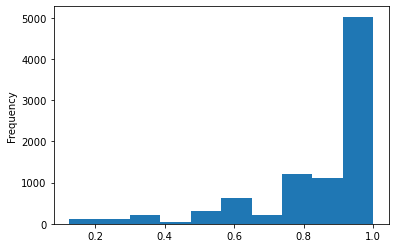

In [106]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [107]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [108]:
ds_nor = dic_df['NorESM'].to_xarray()

In [109]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 630, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... 192.4 192.2
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    ...              ...
    CWP_cut2        (time, lat, lon) object (0.0, 80.91116857142856] ... (0.0...
    CWP_cut2l       (time, lat, lon) float64 0.0 0.0 2.0 2.0 ... nan nan 0.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 68.0 68.0 126.0 ... nan 68.0 68.0
    CWP_cut2lmid    (time, lat, lon) float64 40.0 40.0 127.0 ... nan 40.0 40.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

In [110]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 630, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... 192.4 192.2
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    ...              ...
    CWP_cut2        (time, lat, lon) object (0.0, 80.91116857142856] ... (0.0...
    CWP_cut2l       (time, lat, lon) float64 0.0 0.0 2.0 2.0 ... nan nan 0.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 68.0 68.0 126.0 ... nan 68.0 68.0
    CWP_cut2lmid    (time, lat, lon) float64 40.0 40.0 127.0 ... nan 40.0 40.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

In [111]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 630, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... 192.4 192.2
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    ...              ...
    CWP_cut2        (time, lat, lon) object (0.0, 80.91116857142856] ... (0.0...
    CWP_cut2l       (time, lat, lon) float64 0.0 0.0 2.0 2.0 ... nan nan 0.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 68.0 68.0 126.0 ... nan 68.0 68.0
    CWP_cut2lmid    (time, lat, lon) float64 40.0 40.0 127.0 ... nan 40.0 40.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

In [112]:
ds_nor['COT'].count()

<xarray.DataArray 'COT' ()>
array(7959)

In [113]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 630, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    min_cl_tempair  (time, lat, lon) float64 189.0 188.7 188.8 ... 192.4 192.2
    ceff            (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    cl_time         (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0 0.0
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    ...              ...
    CWP_cut2        (time, lat, lon) object (0.0, 80.91116857142856] ... (0.0...
    CWP_cut2l       (time, lat, lon) float64 0.0 0.0 2.0 2.0 ... nan nan 0.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 68.0 68.0 126.0 ... nan 68.0 68.0
    CWP_cut2lmid    (time, lat, lon) float64 40.0 40.0 127.0 ... nan 40.0 40.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

<AxesSubplot:ylabel='Frequency'>

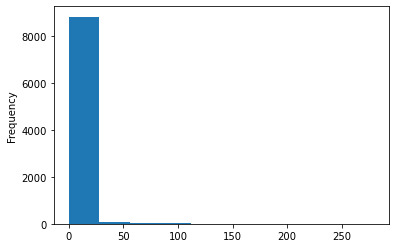

In [114]:
dic_df[model_name_echam]['lcdnc_cm3'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

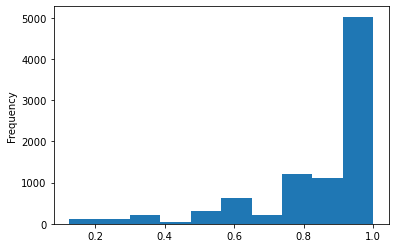

In [115]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

# Calculate difference between high OA and low


In [116]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [117]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [118]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [119]:
from sklearn.utils import resample

## Bootstrap resampling 

In [120]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [121]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key =='EC-Earth') and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
410
length of 68 is 604 and 589
number of days is 180 and 200
1000
length of 96 is 813 and 689
number of days is 184 and 204
1000
length of 126 is 663 and 550
number of days is 183 and 192
1000
length of 156 is 385 and 383
number of days is 159 and 170
1000
length of 188 is 217 and 272
number of days is 121 and 139
1000
length of 220 is 108 and 178
number of days is 80 and 107
1000
length of 278 is 183 and 312
number of days is 104 and 138
1000
NorESM
Total number of days:
376
length of 73 is 273 and 335
number of days is 100 and 124
1000
length of 107 is 455 and 448
number of days is 136 and 143
1000
length of 144 is 548 and 496
number of days is 140 and 157
1000
length of 180 is 482 and 465
number of days is 143 and 140
1000
length of 217 is 358 and 371
number of days is 130 and 134
1000
length of 253 is 231 and 258
number of days is 108 and 116
1000
length of 309 is 278 and 244
number of days is 107 and 112
1000
EC-Earth
Observations
Total number of

In [122]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
2.3324417954507233
NorESM
0.8425746125524618
Observations
0.2741665787167019


In [124]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
Observations


# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_JFM.png


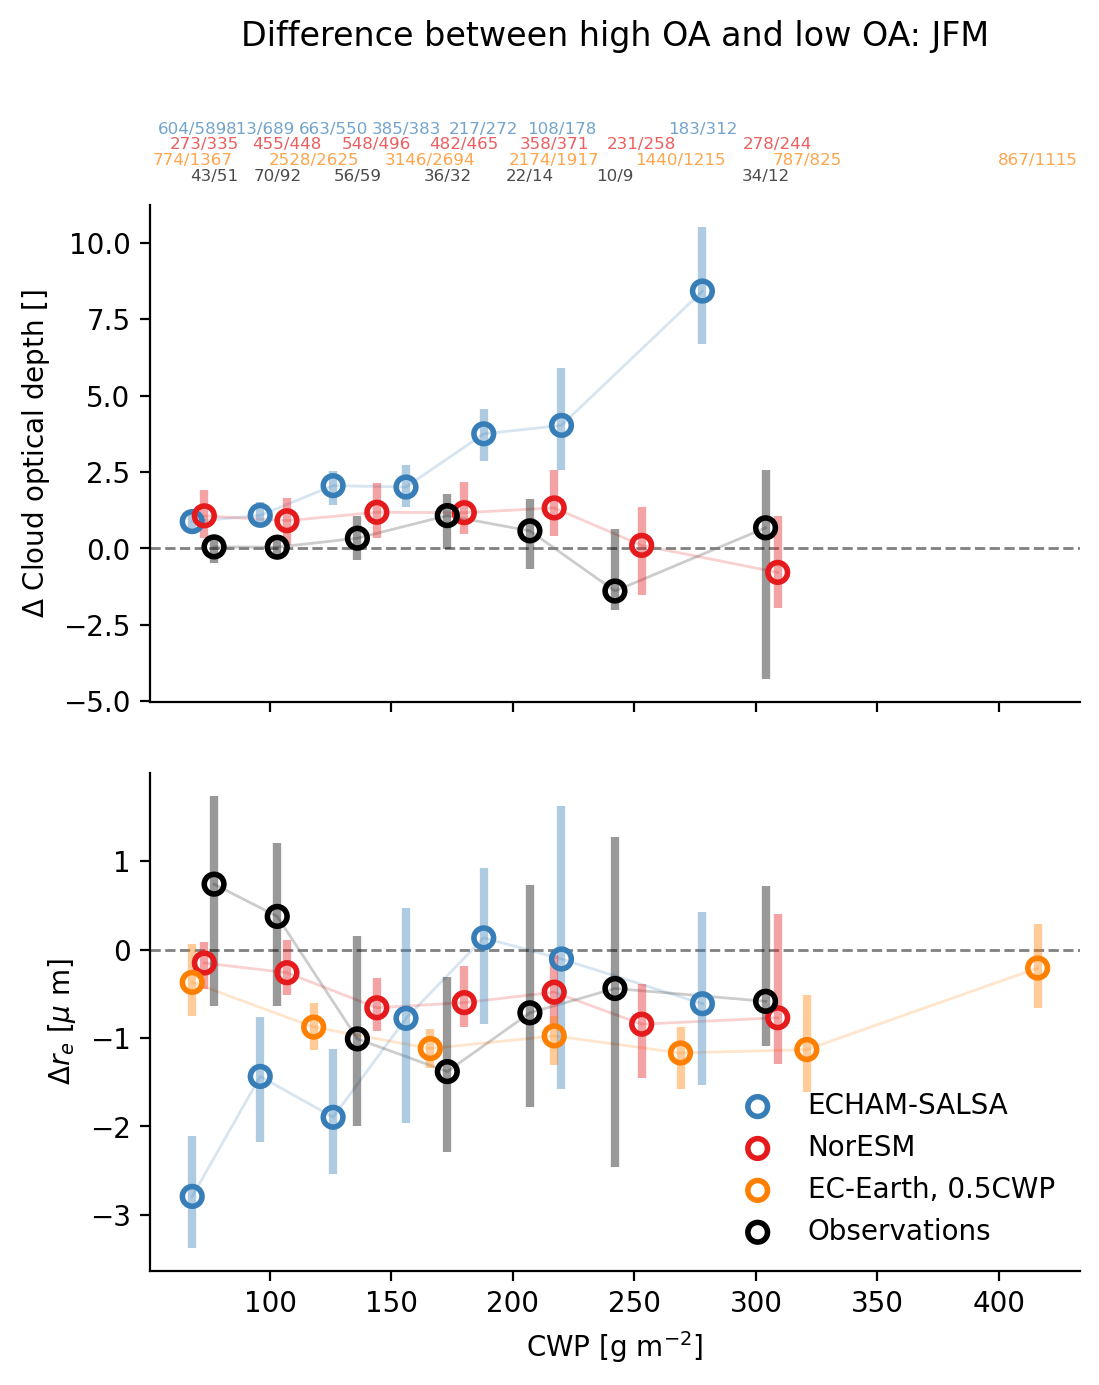

In [126]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_JFM.png


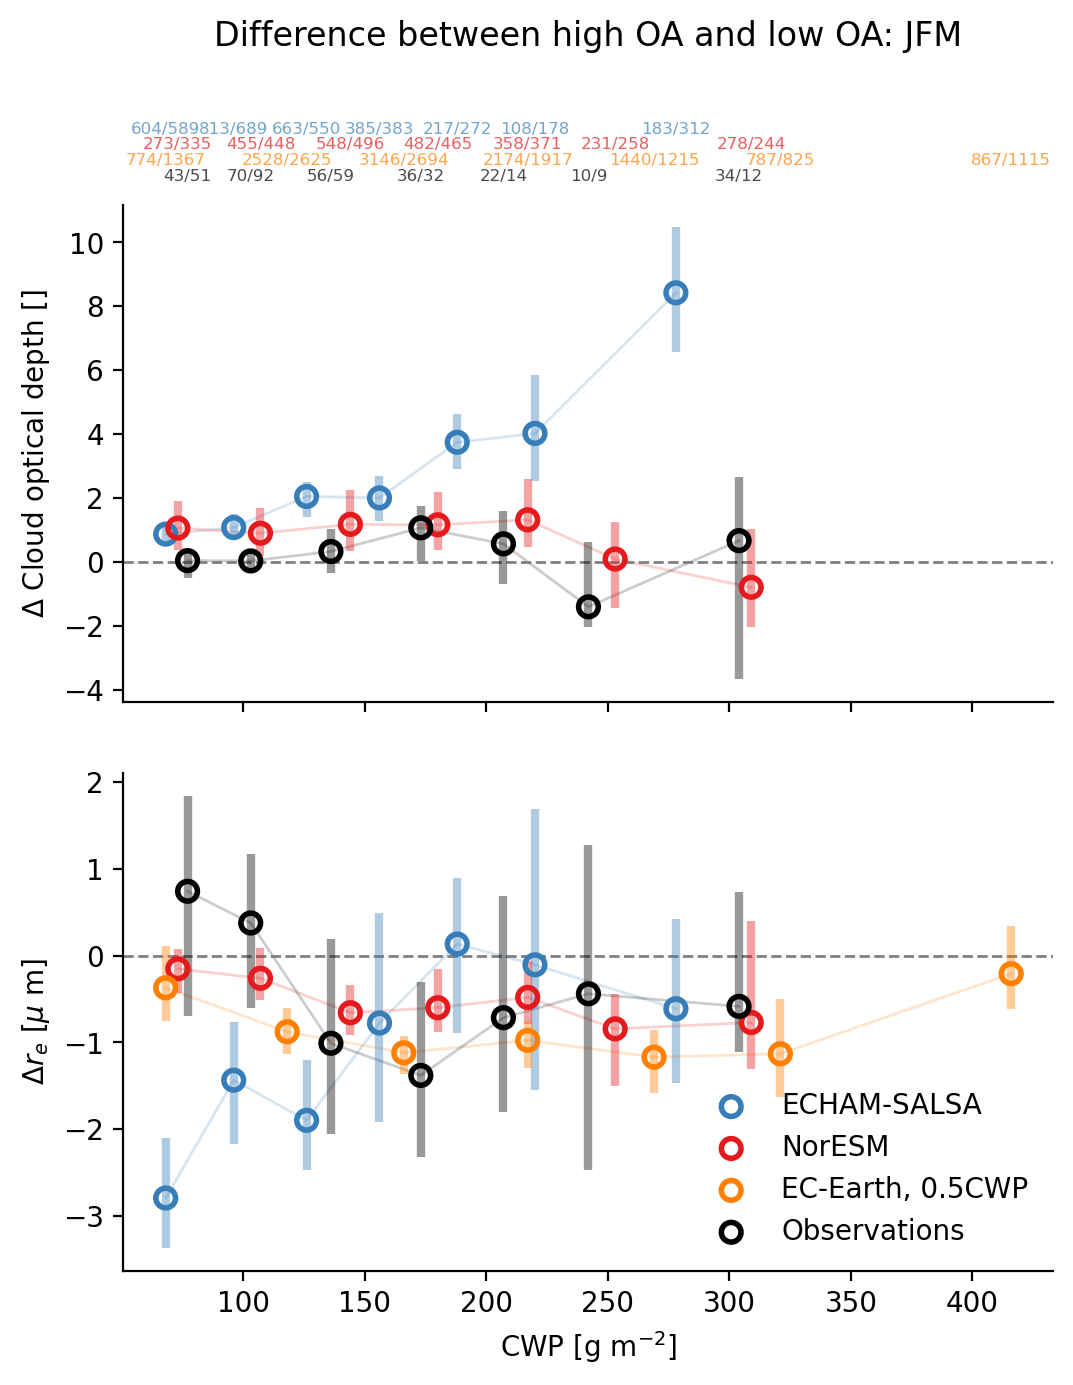

In [522]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [523]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [524]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFM.png


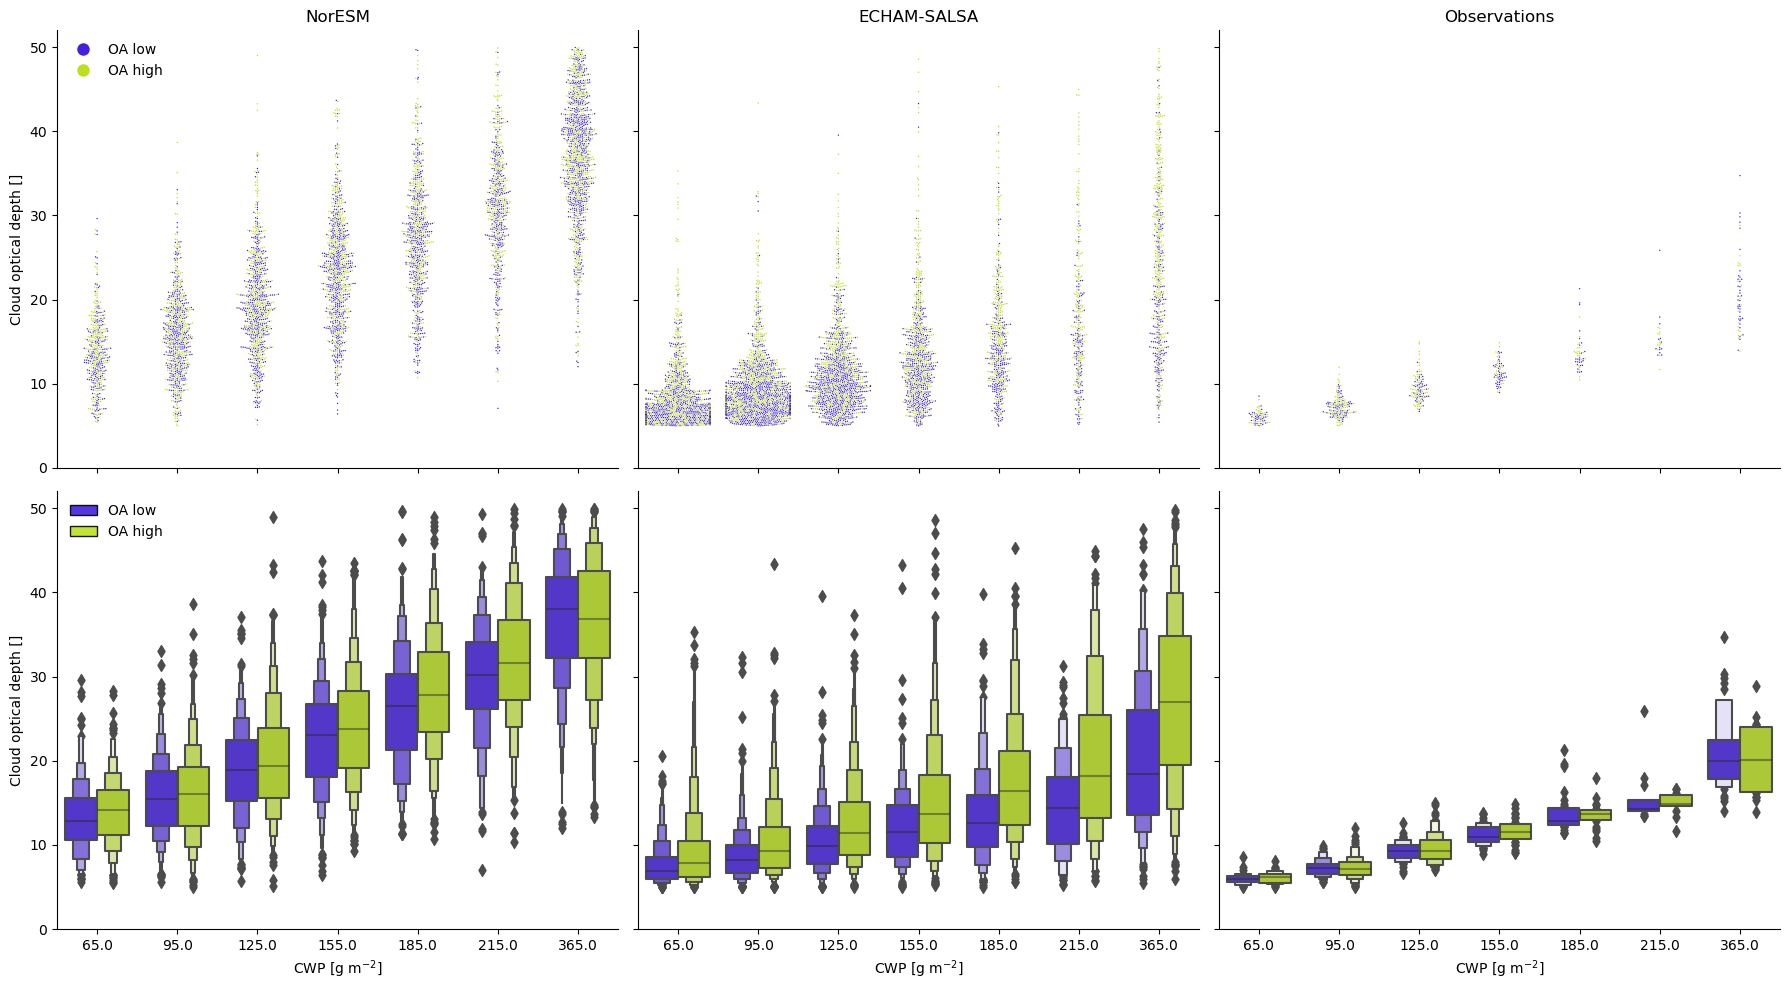

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFM.png


In [525]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


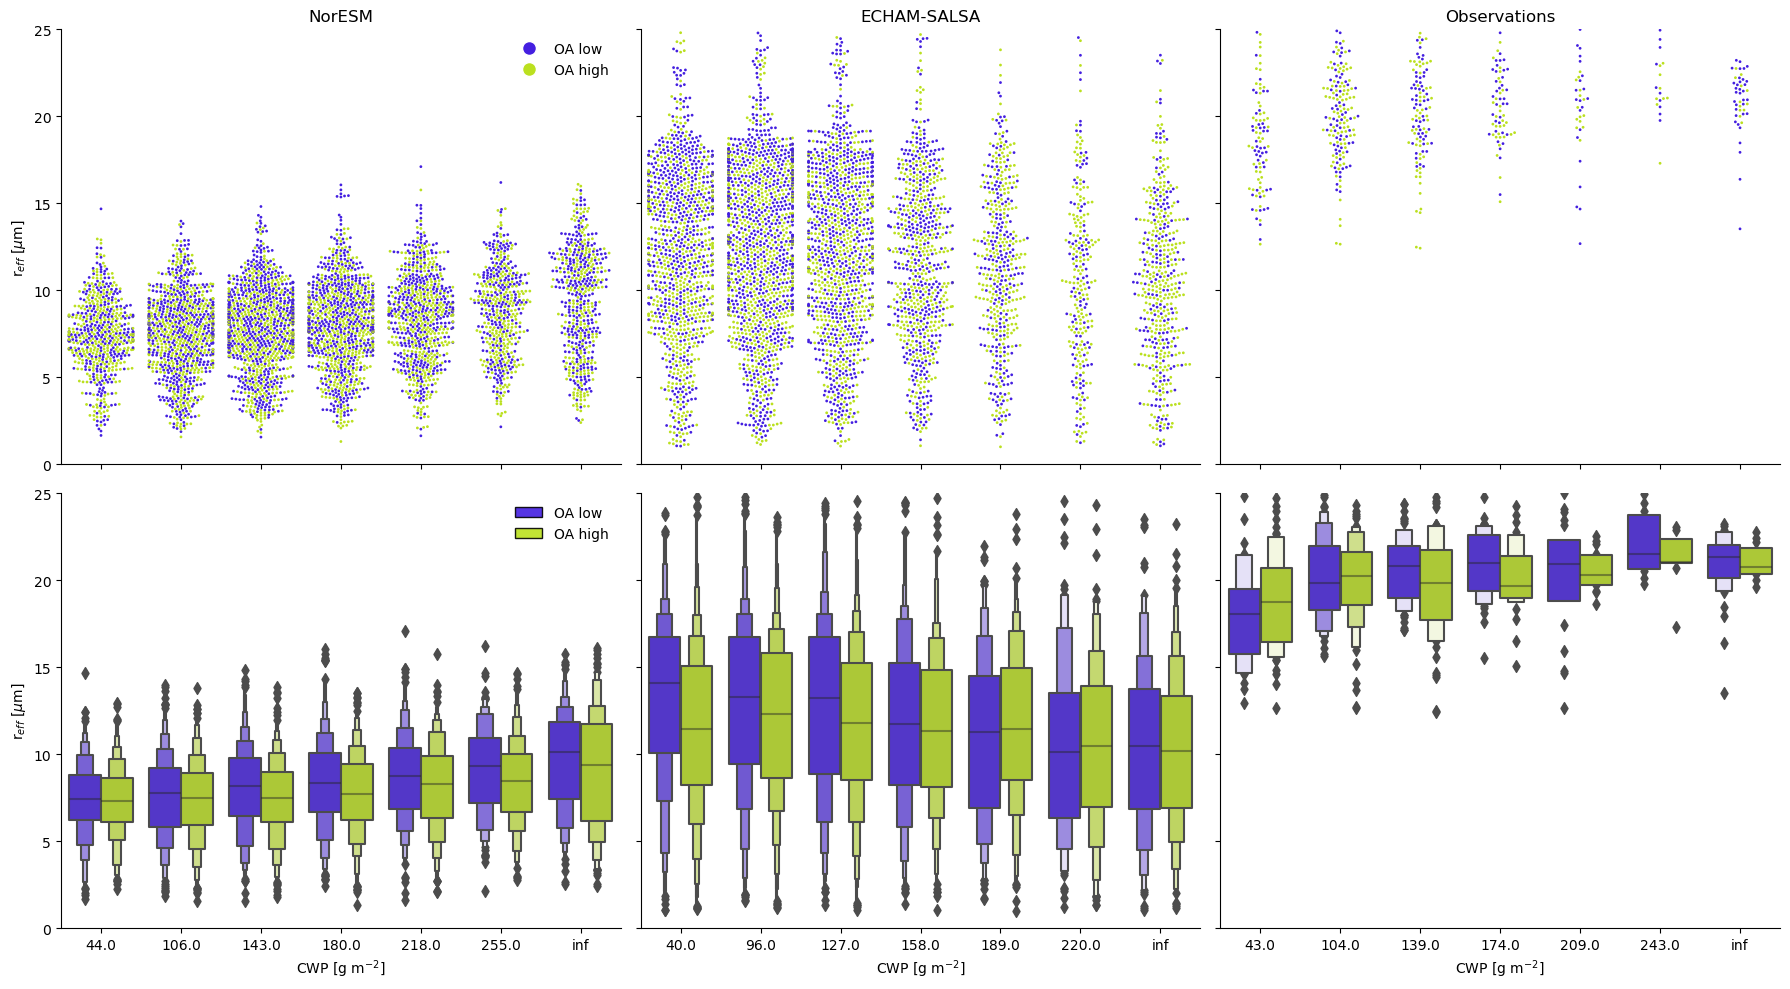

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


In [526]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


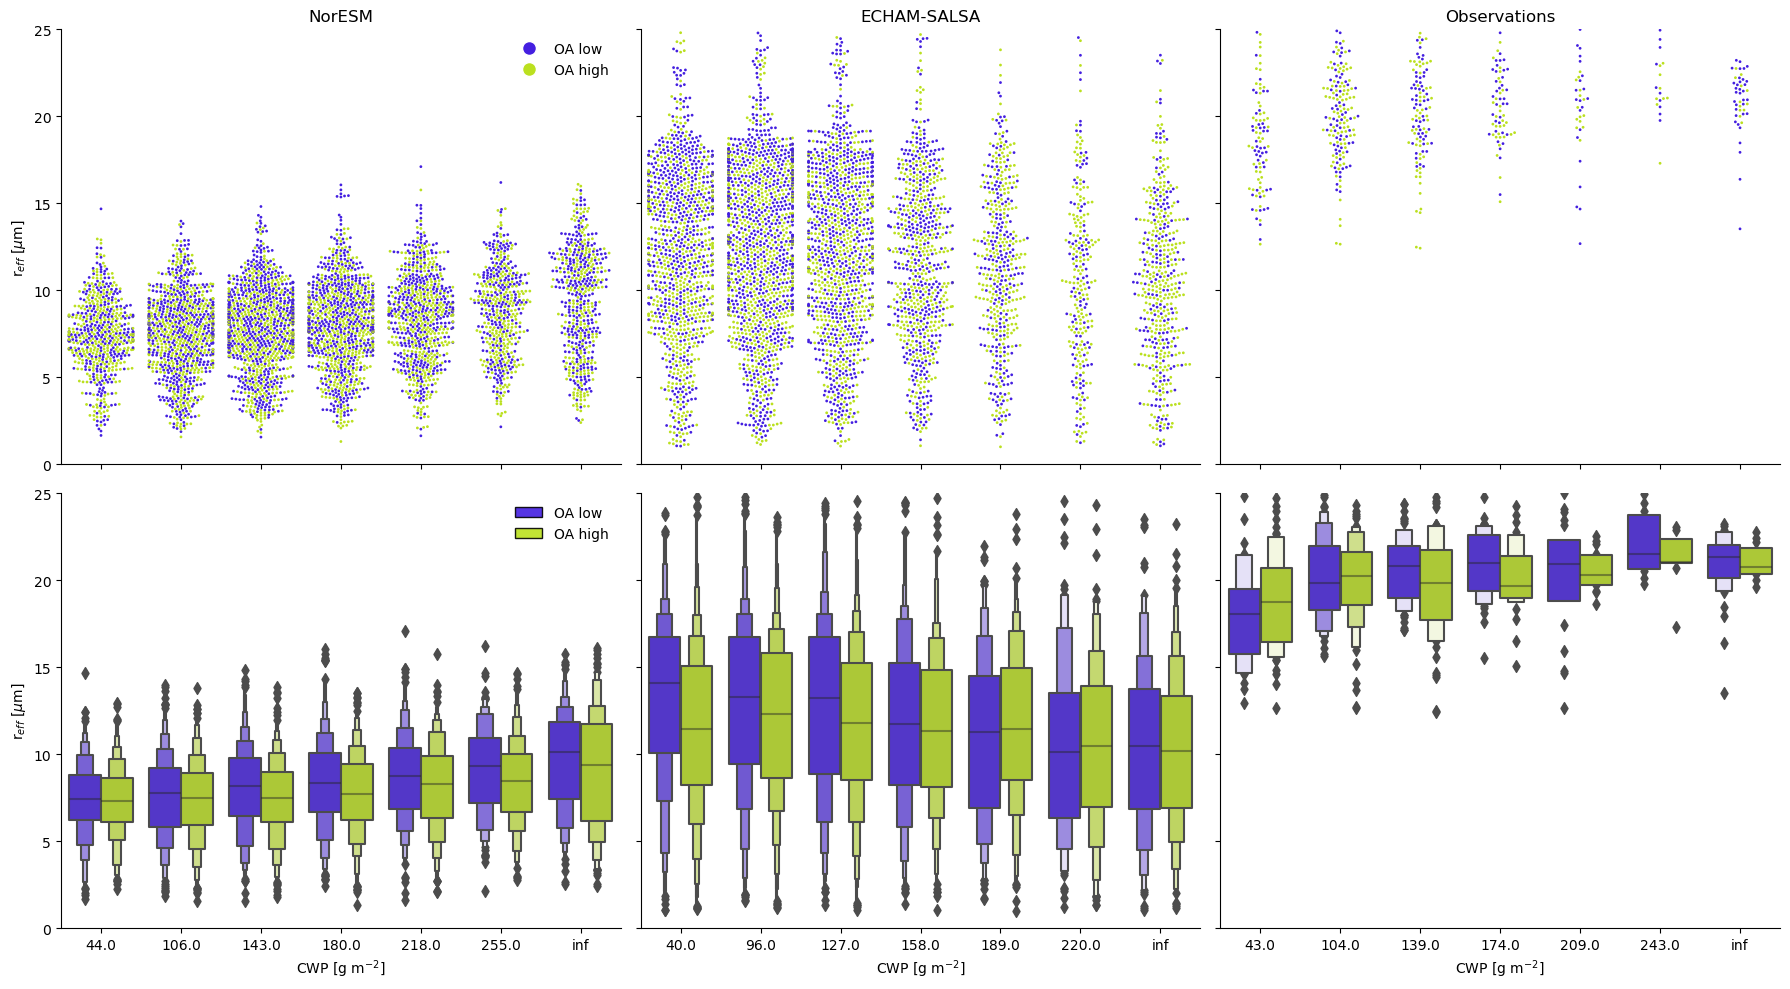

In [527]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 579 and 567
number of days is 180 and 199
10000
length of 94 is 799 and 673
number of days is 182 and 202
10000
length of 124 is 664 and 539
number of days is 182 and 193
10000
length of 153 is 388 and 399
number of days is 162 and 178
10000
length of 184 is 227 and 276
number of days is 124 and 144
10000
length of 215 is 117 and 185
number of days is 89 and 111
10000
length of 272 is 195 and 329
number of days is 107 and 145
10000


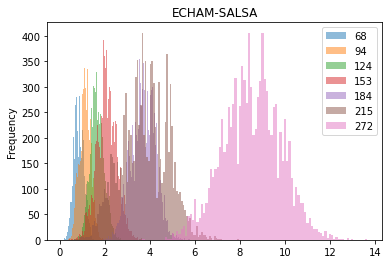

length of 68 is 196 and 240
number of days is 90 and 103
10000
length of 95 is 345 and 353
number of days is 119 and 132
10000
length of 125 is 412 and 385
number of days is 127 and 142
10000
length of 155 is 433 and 411
number of days is 137 and 144
10000
length of 184 is 381 and 364
number of days is 137 and 125
10000
length of 214 is 289 and 308
number of days is 120 and 127
10000
length of 270 is 569 and 556
number of days is 140 and 151
10000


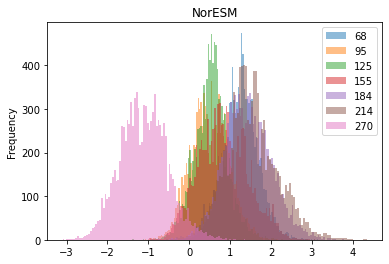

KeyError: 'COT'

In [528]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()